# 1. Set up the notebook

Import modules.

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from IPython.display import display, IFrame, HTML

Define a function to load flight data from hardware experiments and resample it at 100 Hz using linear interpolation.

In [3]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [4]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. Define constants

Define the acceleration of gravity in $\text{kg}\cdot\text{m} \;/\; \text{s}^2$:

In [6]:
g = 9.81

Define the mass of the drone in $\text{kg}$:

In [31]:
m = 35.9 / 1000.
m

0.0359

# 3. Estimate the moment of inertia about the $x$-axis

Define the distance in meters between the axis of rotation and the center of mass:

In [10]:
r = 3.0 / 100
# 1.25 inches

Photo of the x rig.

![x-axis-rig](x-rig.png)

Video of X Rig

In [11]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_9m3hesh4')

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded


In [13]:
data = load_hardware_data(
    'results/x_data.json',
    t_min_offset=5.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [14]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $x$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

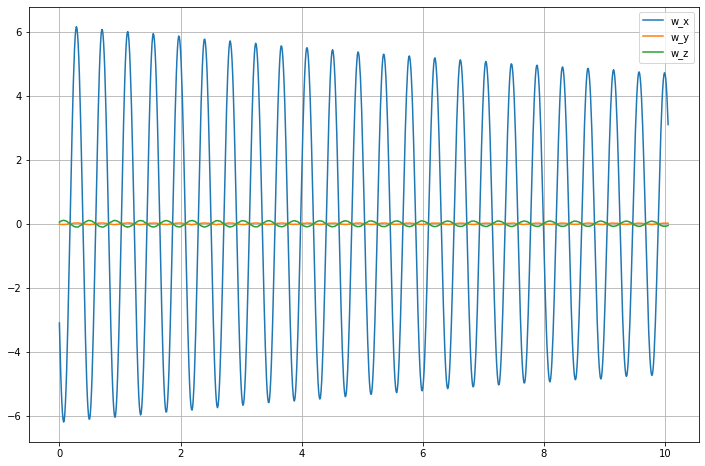

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

You should find that `w_x` is oscillatory. The period is the peak-to-peak time. You could measure the period by hand, but it is easier to automate this process, particularly if you want to average your estimate of the period over many oscillations.

Here is one way to do it:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [16]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_x, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_x_peaks = w_x[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

Sanity check - print the peak times:

In [17]:
print(t_peaks)

[0.28 0.7  1.13 1.55 1.97 2.4  2.82 3.24 3.66 4.09 4.51 4.93 5.35 5.78
 6.2  6.62 7.04 7.46 7.89 8.31 8.73 9.15 9.57 9.99]


Sanity check - plot the peaks:

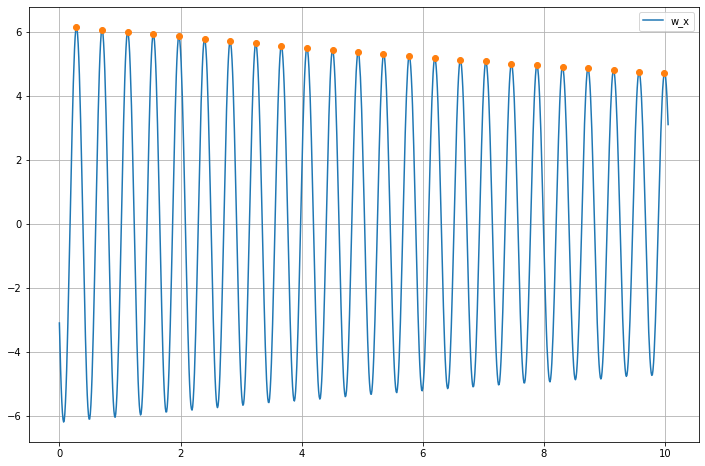

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t_peaks, w_x_peaks, '.', markersize=12)
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [19]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')

time differences: [0.42 0.43 0.42 0.42 0.43 0.42 0.42 0.42 0.43 0.42 0.42 0.42 0.43 0.42
 0.42 0.42 0.42 0.43 0.42 0.42 0.42 0.42 0.42]

period estimate (i.e., mean time difference): T = 0.4222


Compute the moment of inertia about the $x$ axis (see formula from theory).

In [20]:
J_x = m*g*r / (2*np.pi / T)**2 - m*r**2 
J_x

1.5388833881328005e-05

# 4. Estimate the moment of inertia about the $y$-axis

Define the distance in meters between the axis of rotation and the center of mass:

In [21]:
r = 3.0 / 100 
# 1.25 inches

Y-Axis Rig

![y-axis-rig](y-rig.png)

Show a video of the drone swinging on your rig, while you were collecting data (change the url as appropriate):

In [22]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_li0so9h7')

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded

In [23]:
data_y = load_hardware_data(
    'results/y_data.json',
    t_min_offset=5.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [24]:
t = data_y['time']
w_x = np.deg2rad(data_y['gyro.x'])
w_y = np.deg2rad(data_y['gyro.y'])
w_z = np.deg2rad(data_y['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $y$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

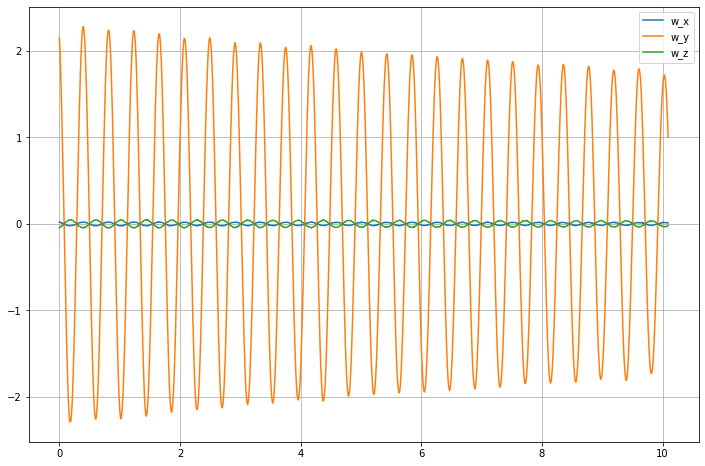

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

You should find that `w_y` is oscillatory. The period is the peak-to-peak time. You could measure the period by hand, but it is easier to automate this process, particularly if you want to average your estimate of the period over many oscillations.

Here is one way to do it:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [26]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_y, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_y_peaks = w_y[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

Sanity check - print the peak times:

In [27]:
print(t_peaks)

[ 0.4   0.81  1.23  1.65  2.07  2.49  2.91  3.33  3.75  4.17  4.59  5.01
  5.43  5.85  6.26  6.68  7.1   7.51  7.94  8.35  8.77  9.19  9.61 10.03]


Sanity check - plot the peaks:

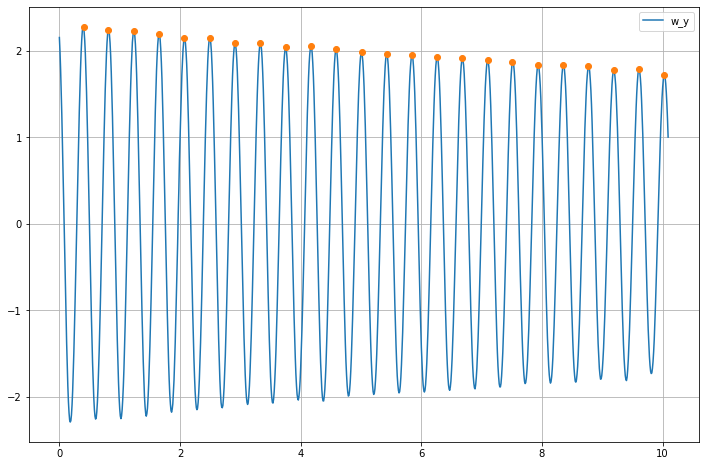

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_y, label='w_y')
plt.plot(t_peaks, w_y_peaks, '.', markersize=12)
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [29]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')

time differences: [0.41 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.41
 0.42 0.42 0.41 0.43 0.41 0.42 0.42 0.42 0.42]

period estimate (i.e., mean time difference): T = 0.4187


Add cells here to repeat the same process as above...

In [30]:
J_y = m*g*r / (2*np.pi / T)**2 - m*r**2 
J_y

1.4606097070124496e-05

# 5. Estimate the moment of inertia about the $z$-axis

Define the distance in meters between the axis of rotation and the center of mass:

In [32]:
# Radius from where nail is to center of drone
r = 1.5 / 100 # <-- FIXME

Z-Axis Rig
![z-axis-rig](z-rig.png)

Z-Axis Video

In [33]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_s23kbffx')

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded


In [40]:
data_z = load_hardware_data(
    'results/z_data.json',
    t_min_offset=0.,
    t_max_offset=8.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [41]:
t = data_z['time']
w_x = np.deg2rad(data_z['gyro.x'])
w_y = np.deg2rad(data_z['gyro.y'])
w_z = np.deg2rad(data_z['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $z$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

In our case, the component in the y and x direction are NOT negligible. This is a source of error on $J_z$

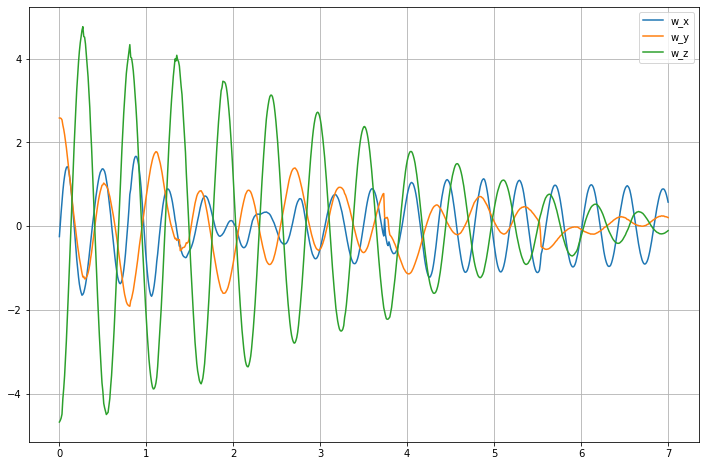

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

 `w_z` is oscillatory. The period is the peak-to-peak time.

Here is one way to automate the period finding process:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [43]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_z, prominence=0.05)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_z at each peak (for visualization)
w_z_peaks = w_z[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

Sanity check - print the peak times:

In [44]:
print(t_peaks)

[0.27 0.81 1.35 1.88 2.43 2.97 3.51 4.04 4.58 5.11 5.63 6.17 6.66]


Sanity check - plot the peaks:

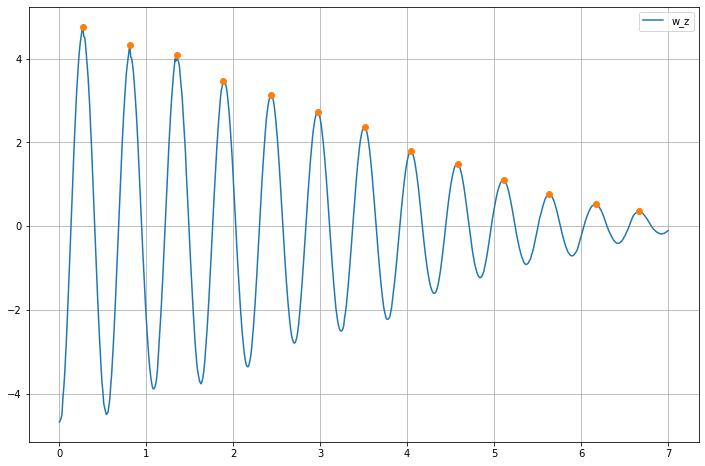

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_z, label='w_z')
plt.plot(t_peaks, w_z_peaks, '.', markersize=12)
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [46]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T:.4f}')

time differences: [0.54 0.54 0.53 0.55 0.54 0.54 0.53 0.54 0.53 0.52 0.54 0.49]

period estimate (i.e., mean time difference): T = 0.5325


Add cells here to repeat the same process as above...

In [47]:
J_z = m*g*r / (2*np.pi / T)**2 - m*r**2 
print("J_z: ", J_z)

J_z:  2.9865721624108755e-05


# 6. Summarize and discuss the results

### Summary of results

In [171]:
print(f'm = {m:.2} kg')
print(f'J_x = {J_x:.2e} kg m^2')
print(f'J_y = {J_y:.2e} kg m^2')
print(f'J_z = {J_z:.2e} kg m^2')

m = 0.031 kg
J_x = 1.56e-05 kg m^2
J_y = 1.67e-05 kg m^2
J_z = 2.75e-05 kg m^2


### Sources of error

* How uncertain was each measurement and each computed quantity?


* What assumptions were made and to what extent were these assumptions violated?

It was assumed that the center of mass of the drone was at the physical center of the drone. The actual center of mass can vary based off of the mass distribution of the hardware.

Additionally, it was assumed that the oscillations were negligible in axis that weren't being tested. For example, when the drone was rotating around the x-axis, it was assumed that the y and z axis oscillations were negligible. In reality, this wasn't the case, especially when oscillation about z was tested.

* Are there ways in which either the experiments or the analysis could be improved?

The drone can be measured with a level prior to swinging to ensure that the motion is isolated about a particular axis.

We can also more accurately estimate the center of the mass of the drone by finding its balancing point.

A better rig for rotation can be created to minimize rotation in other axes.

Finally, a standardized system for rotating the drone can be created instead of human force which changes from trial to trial.


### Analysis of sensitivity

* Find the derivative of $J$ with respect to $m$. If you overestimate the mass, will you have overestimated or underestimated $J$?

$$J = \frac{mgr T^2}{4 \pi ^2} - mr^2$$

$$\frac{\partial J}{\partial m} =  \frac{gr T^2}{4 \pi ^2} - r^2$$

This results in an overestimation value of $J$. Since the partial derivative is positive, as mass increases, so will the moment of inertia

In [172]:
partial_j_m = g*r*T**2 / (4*np.pi**2) - r**2
partial_j_m

0.0008787339470944387

* Find the derivative of $J$ with respect to $r$. If you overestimate the distance between the axis of rotation and the center of mass, will you have overestimated or underestimated $J$?

$$J = \frac{mgr T^2}{4 \pi ^2} - mr^2$$

$$\frac{\partial J}{\partial r} =  \frac{mg T^2}{4 \pi ^2} - 2mr$$

If you overestimate r by a high value, it's very likely that the partial derivative will be negative. This means that an overestimate in r will result in an underestimate in $J$.

In [173]:
partial_j_r = m*g*T**2 / (4*np.pi**2) - 2*m*r
partial_j_r

0.0013641248362703954

* Find the derivative of $J$ with respect to $T$. If you overestimate the period of oscillation, will you have overestimated or underestimated $J$?

$$J = \frac{mgr T^2}{4 \pi ^2} - mr^2$$

$$\frac{\partial J}{\partial T} =  \frac{2 mgr T}{4 \pi ^2}$$

An overestimation in T will result in an overestimation of $J$. The partial derivative will always be positive with respect to T.

In [174]:
partial_j_T = 2*m*g*T / (4*np.pi**2)
partial_j_T

0.008464777346169907